<a href="https://colab.research.google.com/github/elhamkashi/DSPS_EKashi/blob/main/HW5/poblem_2_of_hogg_and_foreman_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2 — Minimal Metropolis–Hastings (Hogg & Foreman-Mackey, 2017)

**Problem 2:** In your scientific programming language of choice, write a very simple MH MCMC sampler. Sample in a single parameter x and give the sampler as its density
function p(x) a Gaussian density with mean 2 and variance 2. (Note that variance is the square of the standard deviation.) Give the sampler a proposal distribution  $q(x ^ \prime \vert x)$ a Gaussian pdf for $x^\prime$ with mean x and variance 1. Initialize the sampler with
x = 0 and run the sampler for more than $10^4$.  Plot the results as a histogram,
with the true density over-plotted sensibly.

A Metropolis-Hastings Markov Chain Monte Carlo (**MH MCMC**) sampler is an algorithm used to generate random samples from any probability distribution, even if we can't directly sample from it.



**Goal:** Implement a tiny Metropolis–Hastings (M–H) sampler for a 1D Gaussian target  
$ p(x) = \mathcal{N}(\mu=2,\ \sigma^2=2) $ using a Gaussian proposal  
$ q(x'|x)=\mathcal{N}(x,\ 1) $, starting at $x_0=0$.  
Run many steps, then plot a histogram of the samples and overlay the true density.


In [35]:
import numpy as np
import matplotlib.pyplot as plt


import scipy.stats as stats
from scipy.stats import norm

Acceptance rate: 0.785


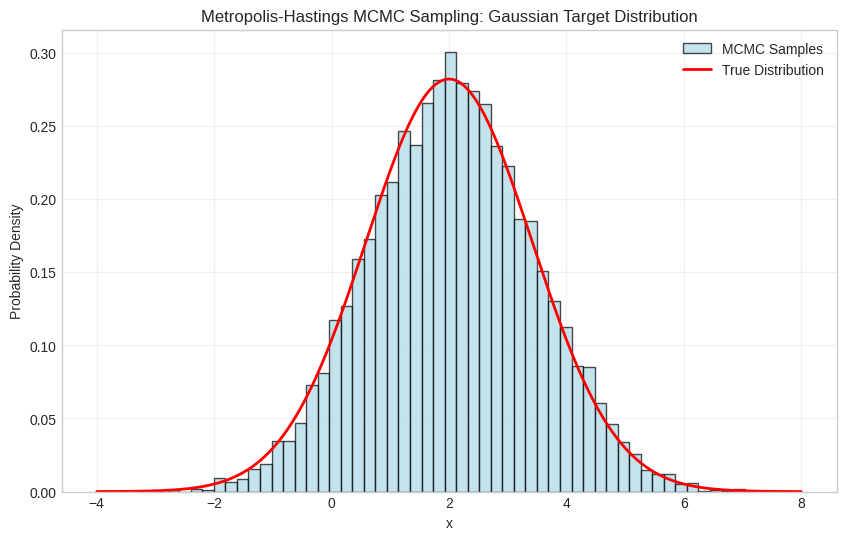

Sample mean: 2.055 (True: 2.000)
Sample variance: 1.967 (True: 2.000)


In [42]:
#method 2:

# Set random seed for reproducibility
np.random.seed(42)

def target_distribution(x):
    """Target distribution: Gaussian with mean=2, variance=2"""
    return stats.norm.pdf(x, loc=2, scale=np.sqrt(2))

def proposal_distribution(current_x):
    """Proposal distribution: Gaussian centered at current_x with variance=1"""
    return np.random.normal(loc=current_x, scale=1)

def metropolis_hastings(n_samples):
    """Metropolis-Hastings MCMC sampler"""
    # Initialize
    x_current = 0.0
    samples = np.zeros(n_samples)
    accepted = 0

    for i in range(n_samples):
        # Generate proposal
        x_proposed = proposal_distribution(x_current)

        # Calculate acceptance ratio
        acceptance_ratio = (target_distribution(x_proposed) /
                          target_distribution(x_current))

        # Accept or reject
        if np.random.uniform(0, 1) < acceptance_ratio:
            x_current = x_proposed
            accepted += 1

        samples[i] = x_current

    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate

# Run MCMC sampler
n_samples = 15000
samples, acceptance_rate = metropolis_hastings(n_samples)

print(f"Acceptance rate: {acceptance_rate:.3f}")

# Plot results
plt.figure(figsize=(10, 6))

# Plot histogram of samples
plt.hist(samples, bins=50, density=True, alpha=0.7,
         label='MCMC Samples', color='lightblue', edgecolor='black')

# Plot true distribution
x_range = np.linspace(-4, 8, 1000)
true_dist = target_distribution(x_range)
plt.plot(x_range, true_dist, 'r-', linewidth=2, label='True Distribution')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Metropolis-Hastings MCMC Sampling: Gaussian Target Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Print some statistics
print(f"Sample mean: {np.mean(samples):.3f} (True: 2.000)")
print(f"Sample variance: {np.var(samples):.3f} (True: 2.000)")
#print(f"First 10 samples: {samples[:10]}")

Metropolis-Hastings MCMC performance for Gaussian target p(x) ~ N(2,2). Proposal distribution: q(x'|x) ~ N(x,1). Chain length: 15,000 steps. Histogram shows posterior samples with true density overlaid in red. The close agreement demonstrates proper mixing and convergence.

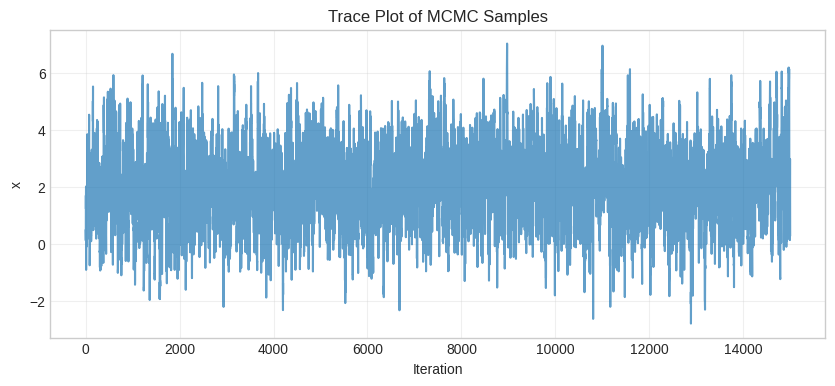

In [41]:
# Plot trace plot to check convergence
plt.figure(figsize=(10, 4))
plt.plot(samples, alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Trace Plot of MCMC Samples')
plt.grid(True, alpha=0.3)
plt.show()


Evolution of the MCMC chain over time. Evolution of the MCMC chain over time.

The key elements to highlight in any trace plot caption are:

*Convergence (does it reach and stay around the true value?)

*Mixing (does it move freely or get stuck?)

*Stationarity (no long-term trends)

*Burn-in (initial adaptation period)

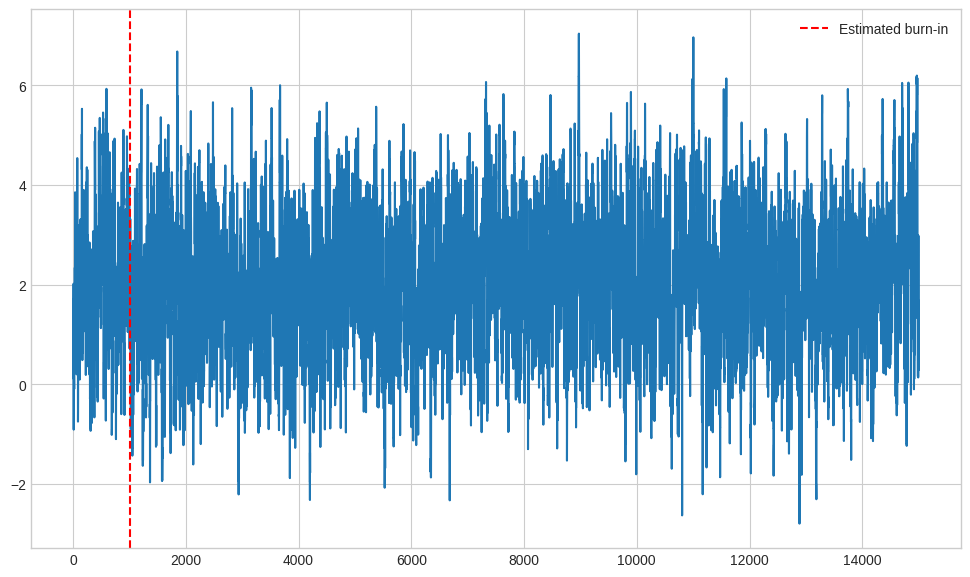

In [43]:
# Plot the entire trace to identify where it stabilizes
plt.plot(samples)
plt.axvline(x=1000, color='red', linestyle='--', label='Estimated burn-in')
plt.legend()